In [52]:
import numpy as np
import pylab as plt
nt = 1000
natom = 864
L = 10.229
Sigma = 3.4
t = np.zeros((nt))
x = np.zeros((natom, 3, nt))
v = np.zeros((natom, 3, nt))

Open and read the Data file, the variable saved will be position (x) and velocity (v), the first axis is index of atom, the second is the direction, the third is time step. Format:
$$x[n = (0,1,2,...),direction (x,y,z), time( ex: 0.1,0.2)] = avlue$$
$$v[n = (0,1,2,...),direction (x,y,z), time( ex: 0.1,0.2)] = avlue$$

In [53]:
with open("Data/Output.lammpstrj") as f:
    for i in range(nt):
        dummy = f.readline()
        t[i] = f.readline()
        for d in range(7):
            dummy = f.readline()
        for j in range(natom):
            dummy = f.readline()
            line = dummy.split()
            for k in range(3):
                x[j, k, i] = float(line[k + 1])
                v[j, k, i] = float(line[k + 4])

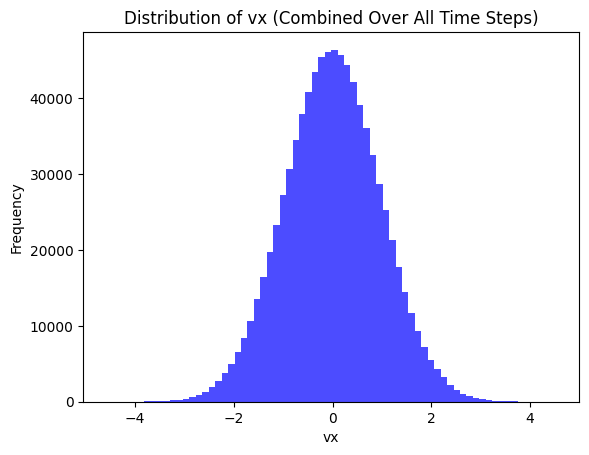

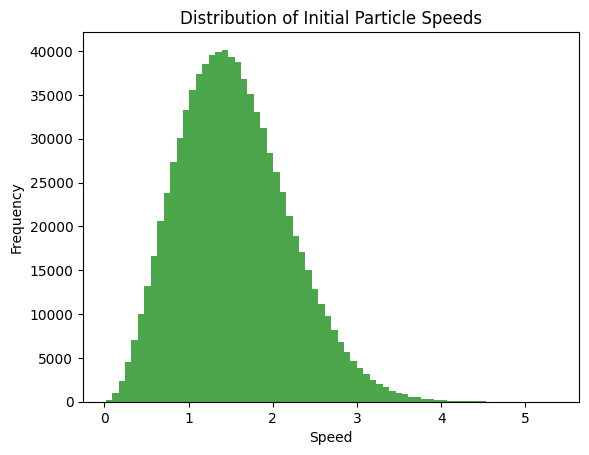

In [74]:
#plot histogram of velocity
# Extract velocity in x direction at the first time step
# Extract velocity in x direction at the first time step
vx_combined = v[:, 0, :].flatten()

# Plot histogram of vx
plt.hist(vx_combined, bins=70, alpha=0.7, color='blue')
plt.xlabel('vx')
plt.ylabel('Frequency')
plt.title('Distribution of vx (Combined Over All Time Steps)')
plt.show()
# Plot histogram of speeds
# Calculate the speed of each particle as the magnitude of the velocity vector at all time steps
speed = np.linalg.norm(v, axis=1).flatten()  # Flatten to combine all time steps
plt.hist(speed, bins=70, alpha=0.7, color='green')
plt.xlabel('Speed')
plt.ylabel('Frequency')
plt.title('Distribution of Initial Particle Speeds')
plt.show()

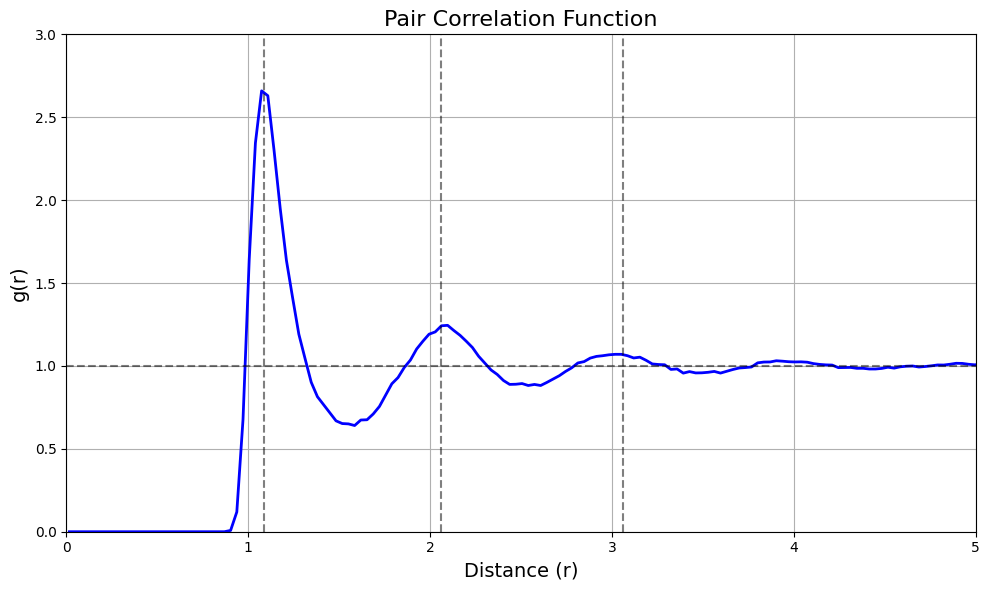

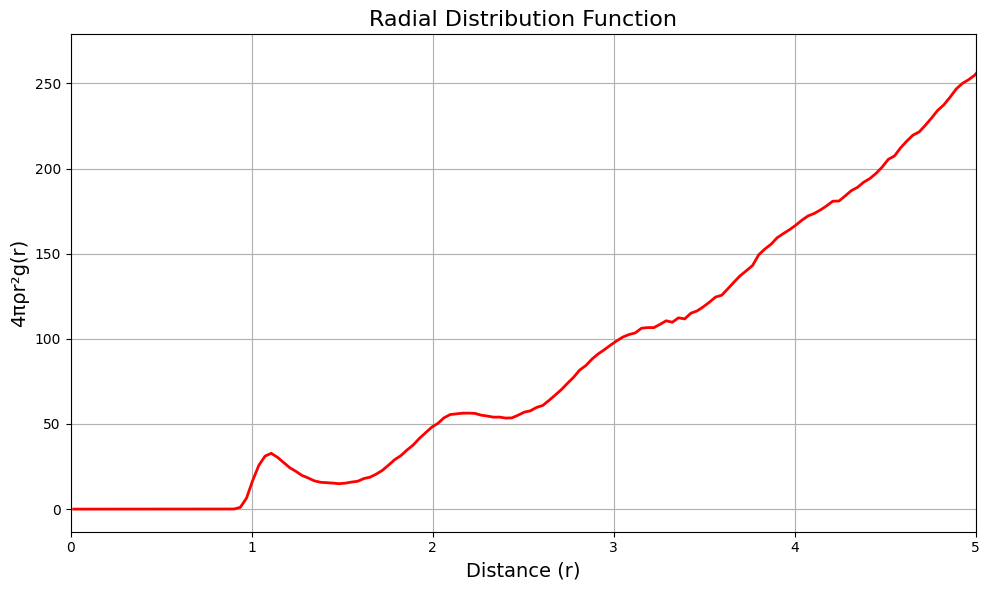

In [55]:
def compute_pair_correlation(positions, box_length, nbins=100, r_max=None):
    """
    Compute the pair correlation function g(r) for a system of particles.
    
    Parameters:
    positions (numpy.ndarray): Positions of atoms at a specific time step, shape (natom, 3)
    box_length (float): Length of the simulation box (assuming cubic)
    nbins (int): Number of bins for histogram
    r_max (float): Maximum distance to consider (defaults to half box length)
    
    Returns:
    r (numpy.ndarray): Radial distance values
    g_r (numpy.ndarray): Pair correlation function values
    """
    natom = positions.shape[0]
    
    # If r_max is not specified, use half of the box length
    if r_max is None:
        r_max = box_length / 2.0
    
    # Create bins for the histogram
    bins = np.linspace(0, r_max, nbins + 1)
    r = 0.5 * (bins[1:] + bins[:-1])  # Centers of bins
    dr = bins[1] - bins[0]  # Bin width
    
    # Initialize histogram for pair distances
    hist = np.zeros(nbins)
    
    # Calculate all pairwise distances considering periodic boundary conditions
    for i in range(natom):
        for j in range(i+1, natom):
            # Calculate distance vector, accounting for periodic boundary conditions
            dx = positions[i, 0] - positions[j, 0]
            dy = positions[i, 1] - positions[j, 1]
            dz = positions[i, 2] - positions[j, 2]
            
            # Apply minimum image convention
            dx = dx - box_length * np.round(dx / box_length)
            dy = dy - box_length * np.round(dy / box_length)
            dz = dz - box_length * np.round(dz / box_length)
            
            # Calculate distance
            r_ij = np.sqrt(dx**2 + dy**2 + dz**2)
            
            # Add to histogram if within range
            if r_ij < r_max:
                bin_index = int(r_ij / dr)
                if bin_index < nbins:
                    hist[bin_index] += 2  # Count each pair twice (i->j and j->i)
    
    # Normalize histogram to get g(r)
    # Volume of the shell at distance r with width dr
    shell_volume = 4.0 * np.pi * r**2 * dr
    
    # Number density of the system
    number_density = natom / (box_length**3)
    
    # Expected number of particles in each shell for an ideal gas
    ideal_count = number_density * shell_volume
    
    # Normalize to get g(r)
    g_r = hist / (natom * ideal_count)
    
    return r, g_r

# Calculate g(r) for multiple time steps and average
def average_pair_correlation(x, box_length, time_steps=10, nbins=100):
    """
    Calculate the average pair correlation function over multiple time steps.
    
    Parameters:
    x (numpy.ndarray): Positions of atoms for all time steps, shape (natom, 3, nt)
    box_length (float): Length of the simulation box
    time_steps (int): Number of time steps to use for averaging
    nbins (int): Number of bins for histogram
    
    Returns:
    r (numpy.ndarray): Radial distance values
    g_r_avg (numpy.ndarray): Average pair correlation function values
    """
    natom, _, nt = x.shape
    
    # Use equally spaced time steps for averaging
    step = nt // time_steps
    selected_times = np.arange(0, nt, step)[:time_steps]
    
    # Initialize arrays
    r = None
    g_r_avg = np.zeros(nbins)
    
    # Calculate g(r) for each selected time step
    for t_idx in selected_times:
        positions = x[:, :, t_idx]
        r, g_r = compute_pair_correlation(positions, box_length, nbins)
        g_r_avg += g_r
    
    # Average over all time steps
    g_r_avg /= len(selected_times)
    
    return r, g_r_avg

# Calculate and plot the pair correlation function
r, g_r = average_pair_correlation(x, L, time_steps=20, nbins=150)

plt.figure(figsize=(10, 6))
plt.plot(r, g_r, 'b-', linewidth=2)
plt.xlabel('Distance (r)', fontsize=14)
plt.ylabel('g(r)', fontsize=14)
plt.title('Pair Correlation Function', fontsize=16)
plt.grid(True)
plt.vlines(x=(3.7/Sigma), color='k', linestyle='--', alpha=0.5, ymin = 0, ymax = 5)
plt.vlines(x=(7.0/Sigma), color='k', linestyle='--', alpha=0.5, ymin = 0, ymax = 5)
plt.vlines(x=(10.4/Sigma), color='k', linestyle='--', alpha=0.5, ymin = 0, ymax = 5)
plt.xlim(0, min(5, L/2))
plt.ylim(0, 3)
plt.axhline(y=1, color='k', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Also display the radial distribution function (RDF) which is 4πρr²g(r)
rho = natom / L**3  # Number density
rdf = 4 * np.pi * rho * r**2 * g_r

plt.figure(figsize=(10, 6))
plt.plot(r, rdf, 'r-', linewidth=2)
plt.xlabel('Distance (r)', fontsize=14)
plt.ylabel('4πρr²g(r)', fontsize=14)
plt.title('Radial Distribution Function', fontsize=16)
plt.grid(True)
plt.xlim(0, min(5, L/2))
plt.tight_layout()
plt.show()

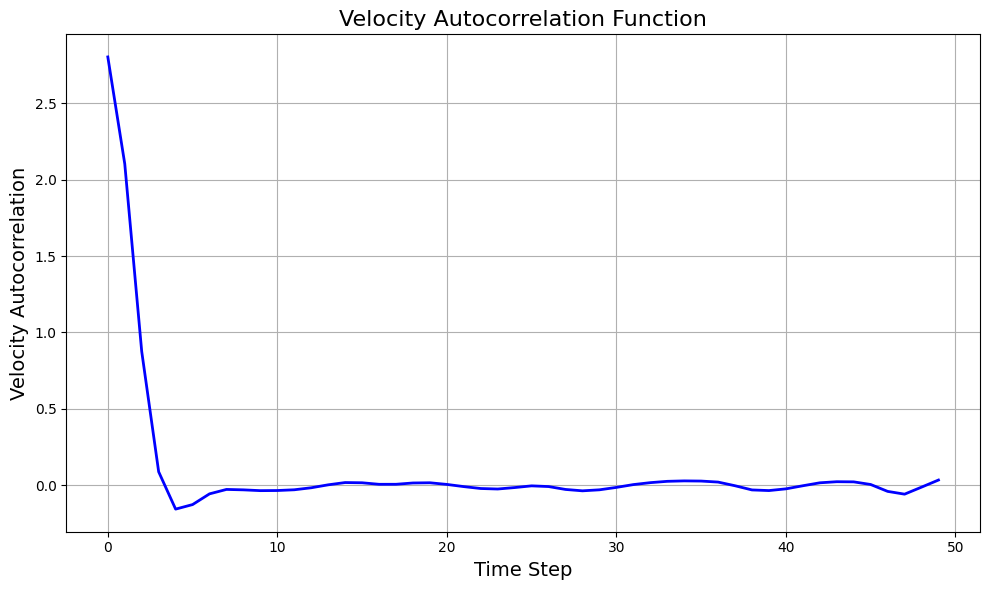

In [56]:
def velocity_correlation(v, nt):
    """
    Calculate the velocity autocorrelation function.

    Parameters:
    v (numpy.ndarray): Velocity array of shape (natom, 3, nt)
    nt (int): Number of time steps

    Returns:
    numpy.ndarray: Velocity autocorrelation function
    """
    natom = v.shape[0]
    vacf = np.zeros(nt)

    for t in range(nt):
        for tau in range(nt - t):
            vacf[t] += np.sum(v[:, :, tau] * v[:, :, tau + t])
        vacf[t] /= (natom * (nt - t))

    return vacf
ntpl = 50
# Calculate velocity autocorrelation function
vacf = velocity_correlation(v, ntpl)

# Plot velocity autocorrelation function
plt.figure(figsize=(10, 6))
plt.plot(np.arange(ntpl), vacf, 'b-', linewidth=2)
plt.xlabel('Time Step', fontsize=14)
plt.ylabel('Velocity Autocorrelation', fontsize=14)
plt.title('Velocity Autocorrelation Function', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


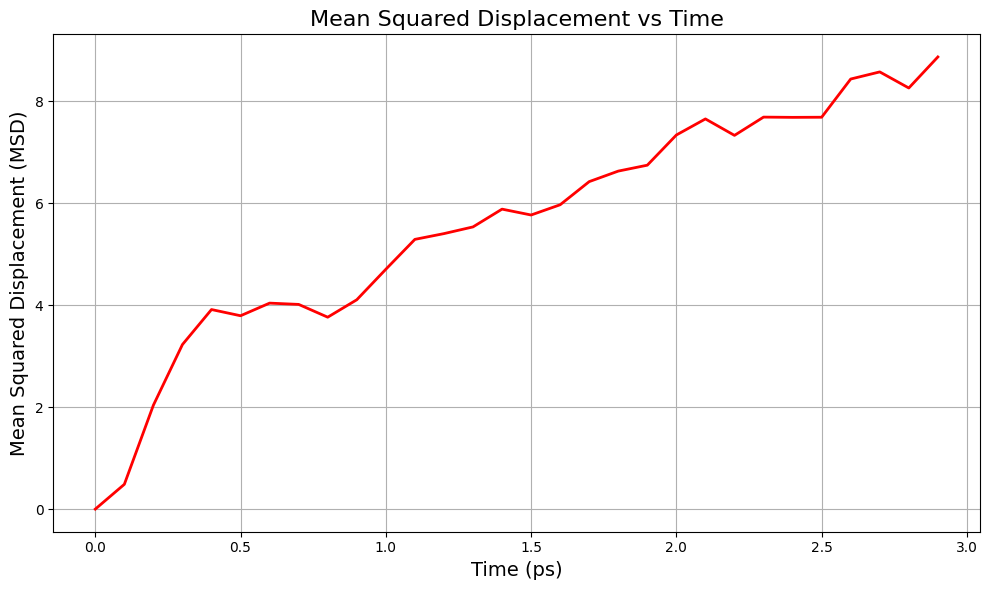

In [68]:
ntpl = 30
msd = np.zeros(ntpl)
for nts in range(ntpl):
    msd[nts] = np.mean(np.sum((x[:, :, nts] - x[:, :, 0])**2, axis=1))
plt.figure(figsize=(10, 6))
plt.plot(np.arange(ntpl)/10, msd, 'r-', linewidth=2)
plt.xlabel('Time (ps)', fontsize=14)
plt.ylabel('Mean Squared Displacement (MSD)', fontsize=14)
plt.title('Mean Squared Displacement vs Time', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()